# Questions

1. Is there a relationship between the predictors (age and ingredients) and the response variable (compressive strength)?

**Given there is a relationship:**

2. How strong is it?
3. Which predictors contribute to compressive strength?
4. How large is the effect of each predictor on compressive strength?
5. How accurately can I predict compressive strength?
6. Is the relationship linear?
7. Is there synergy/interaction among the predictors?

# 1. Import packages and Data

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
concrete_data = pd.read_csv('../input/yeh-concret-data/Concrete_Data_Yeh.csv')

# 2. Initial EDA and Distributions

In [3]:
#look at formatting of entries
concrete_data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
#look at null count and dtype
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
#look at distribution of data
concrete_data.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


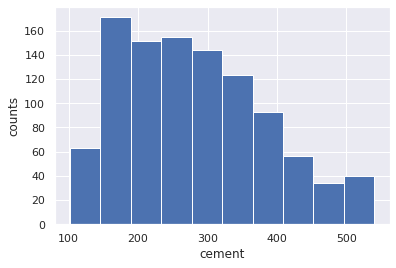

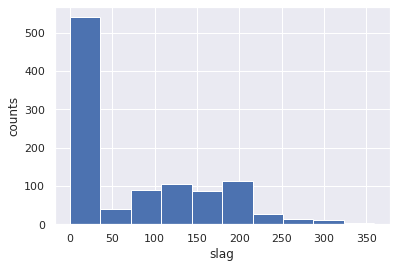

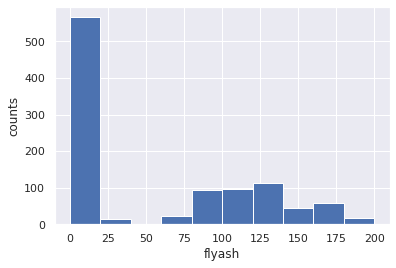

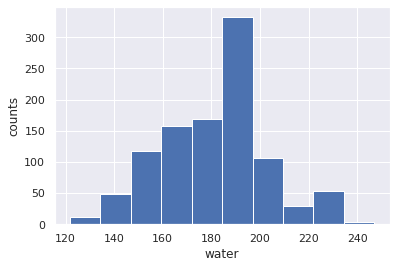

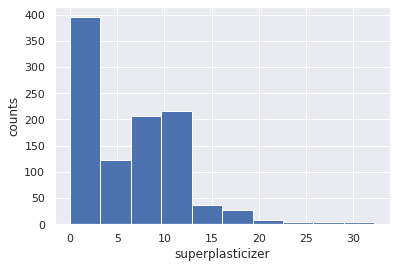

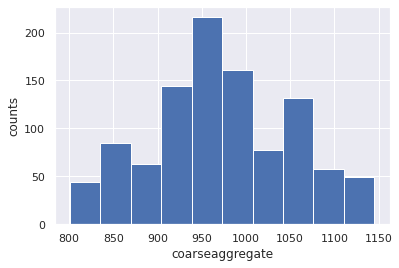

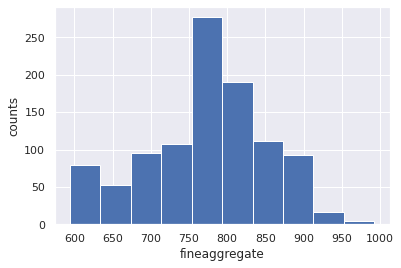

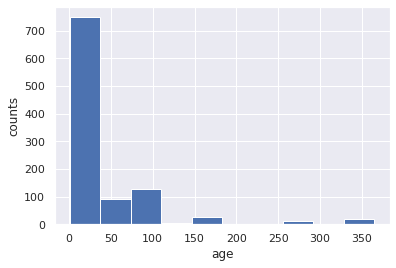

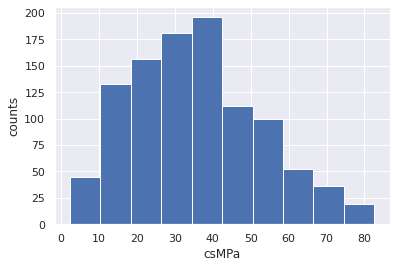

In [6]:
#look at data distribution
for i in concrete_data.columns:
    plt.hist(concrete_data[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

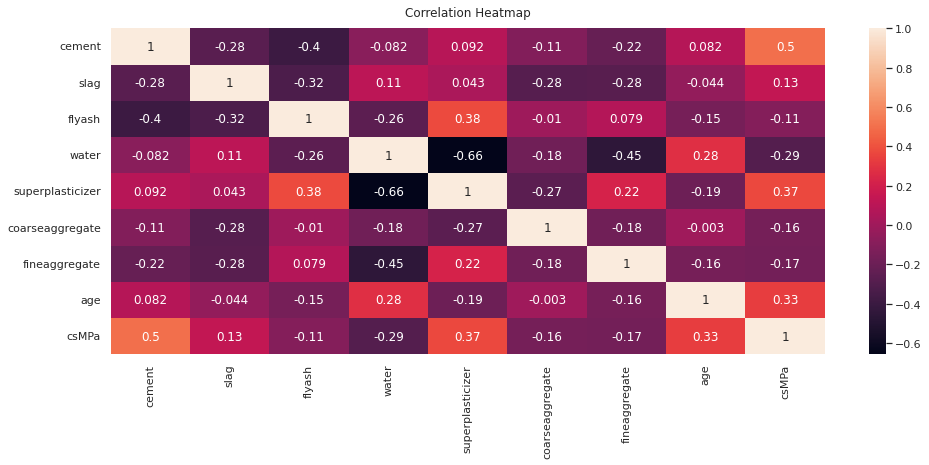

In [7]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(concrete_data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [8]:
#create bins from compressive strength
bins = pd.qcut(concrete_data['csMPa'], q=4)

#add bins to concrete df
concrete_data['bins']=bins

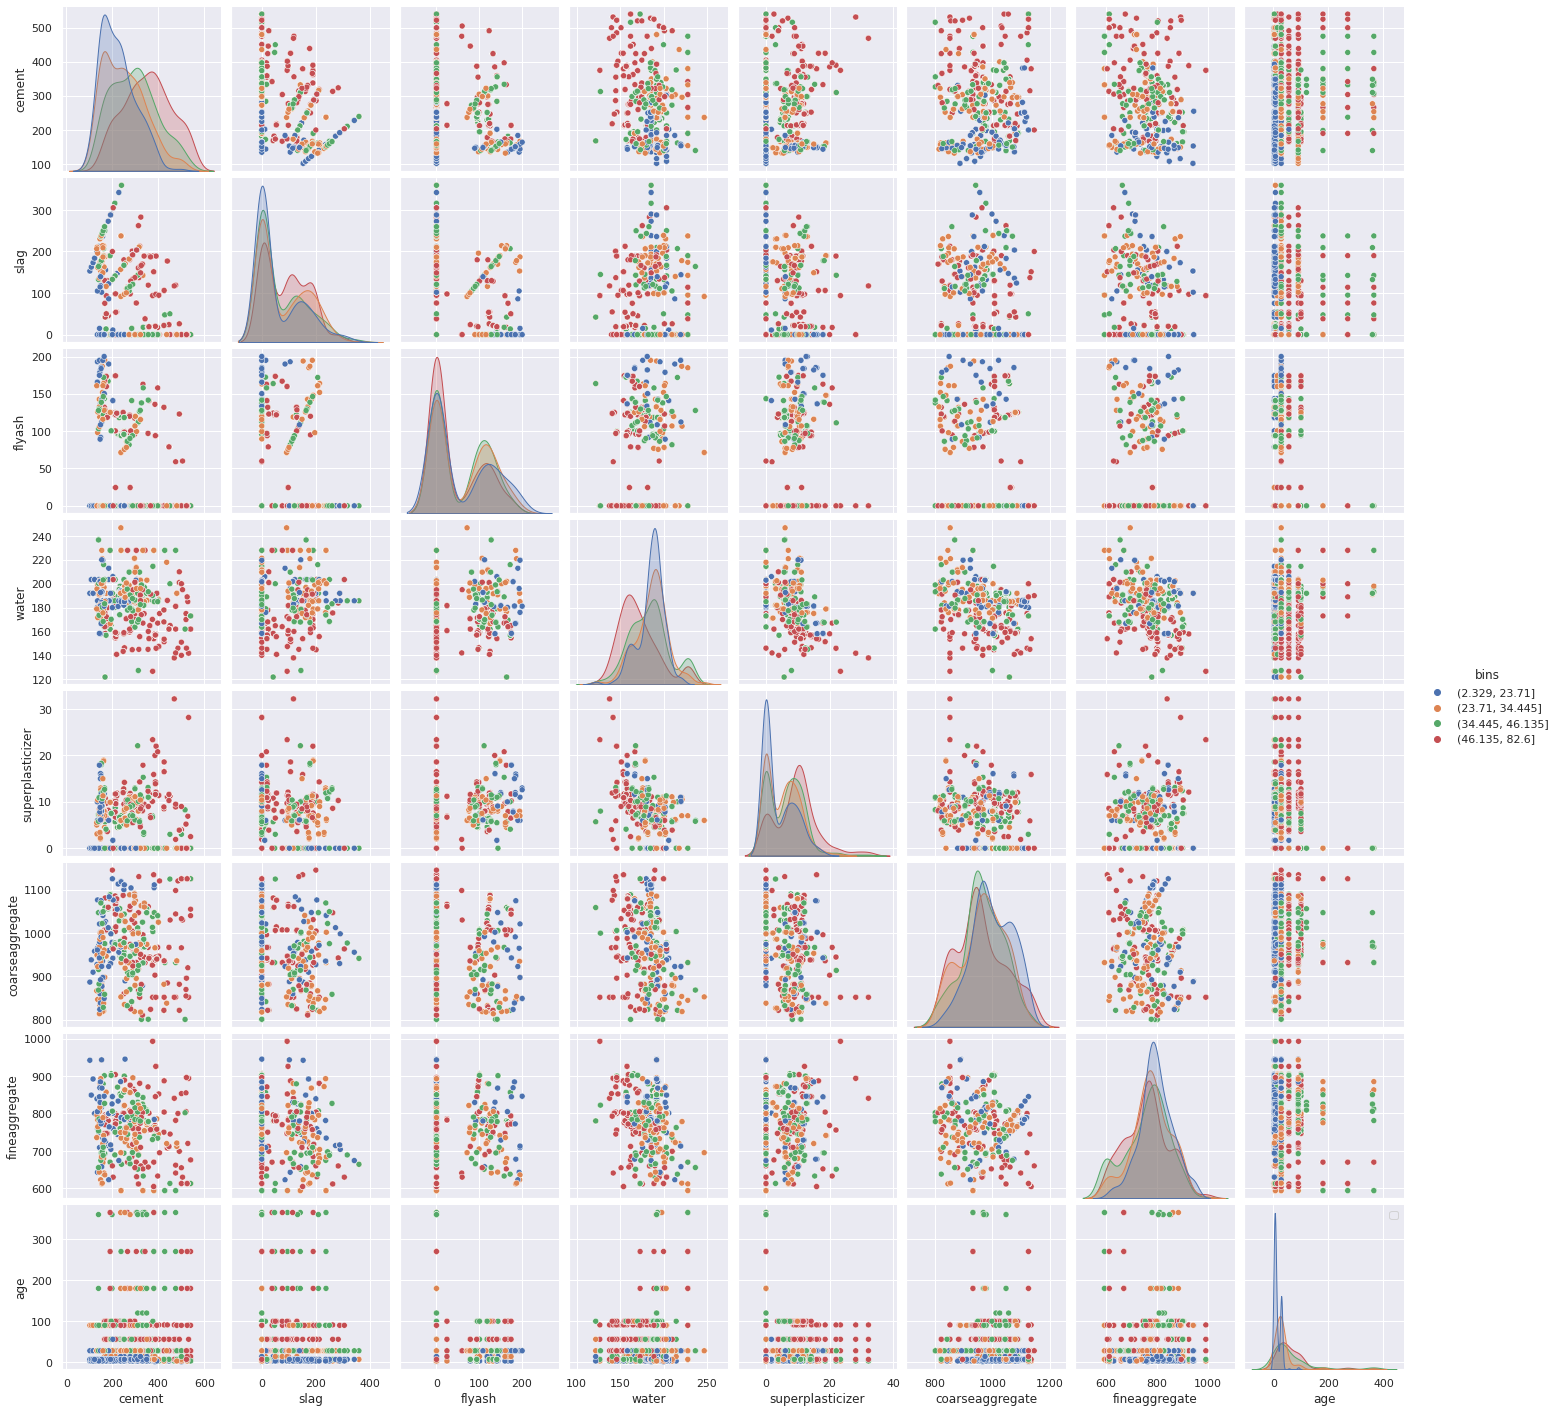

In [9]:
#look at how target is distributed among variables
sns.pairplot(concrete_data.loc[:, (concrete_data.columns != 'csMPa')], hue='bins')
plt.legend()
plt.show()

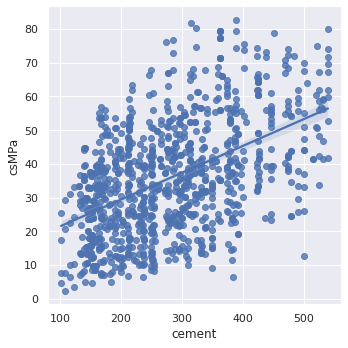

In [10]:
#plot strongest linear correlation
sns.lmplot(x='cement', y='csMPa',data=concrete_data)
plt.show()

In [11]:
#drop bins from concrete data
concrete_data = concrete_data.drop('bins', axis=1)

In [12]:
#copy of variables and target
X = concrete_data.copy()
y = X.pop('csMPa')

# 3. Mutual Information

In [13]:
#make a copy of features matrix for mutual information analysis
X_mi = X.copy()

#label encoding for categorical variables
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

#all discrete features have int dtypes
discrete_features = X_mi.dtypes == object

In [14]:
#some continuous variables also have int dtypes
discrete_features[X_mi.columns] = False

In [15]:
#use regression since the target variable is continuous
from sklearn.feature_selection import mutual_info_regression

#define a function to produce mutual information scores
def make_mi_scores(X_mi, y, discrete_features):
    mi_scores = mutual_info_regression(X_mi, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#compute mutual information scores
mi_scores = make_mi_scores(X_mi, y, discrete_features)
mi_scores

water               0.359076
age                 0.358395
cement              0.309544
coarseaggregate     0.256413
fineaggregate       0.209647
superplasticizer    0.209488
slag                0.183057
flyash              0.120885
Name: MI Scores, dtype: float64

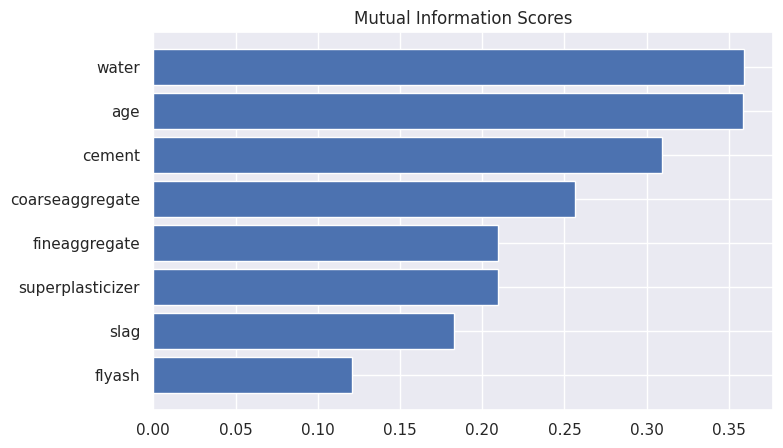

In [16]:
#define a function to plot mutual information scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

#plot the scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

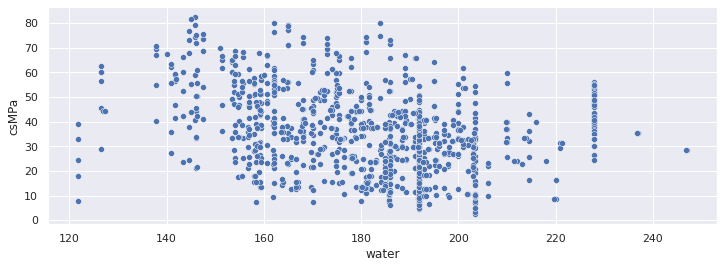

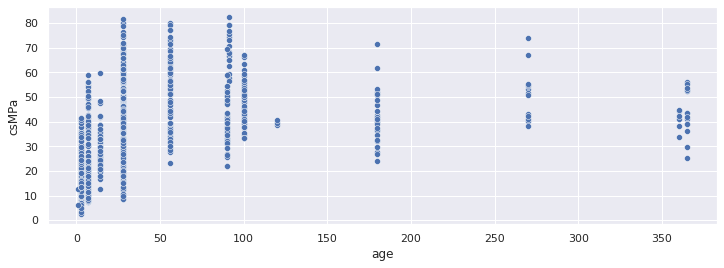

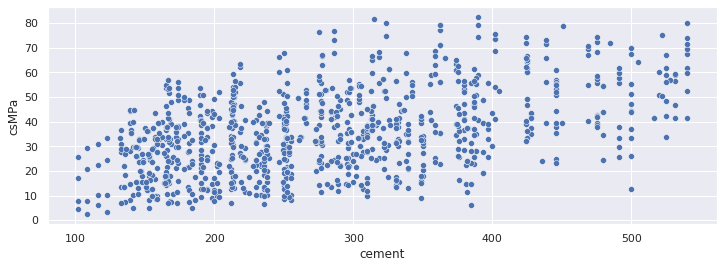

In [17]:
#plot top MI score predictors against target
for i in ['water', 'age', 'cement']:
    fig, ax = plt.subplots(figsize=(12,4))
    sns.scatterplot(x=X_mi[i], y=y, ax=ax)
    plt.show()

# 4. Principal Component Analysis

In [18]:
#copy features matrix for principal component analysis
X_for_PCA = X.copy()

#standardize
X_for_PCA_scaled = (X_for_PCA - X_for_PCA.mean(axis=0)) / X_for_PCA.std(axis=0)

from sklearn.decomposition import PCA

#create principal components
pca = PCA(len(X.columns))
X_pca = pca.fit_transform(X_for_PCA_scaled)

#convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

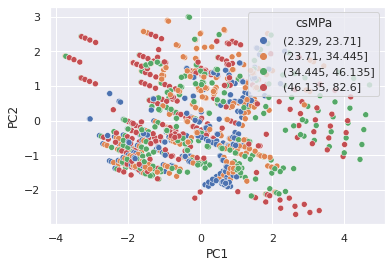

In [19]:
#plot data using principal components
sns.scatterplot(x=X_pca.loc[:,'PC1'],y=X_pca.loc[:,'PC2'], hue=bins)
plt.show()

In [20]:
#determine loadings
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
cement,0.098401,-0.113737,0.814202,-0.054297,0.148206,-0.203142,0.221844,0.446163
slag,0.177262,0.686053,-0.171794,-0.362699,-0.020932,0.304882,0.228363,0.437384
flyash,-0.394662,-0.142948,-0.408221,0.226751,0.549631,-0.183267,0.352463,0.381886
water,0.547004,0.053256,-0.213190,0.296060,0.070222,-0.365970,-0.524275,0.388741
superplasticizer,-0.505945,0.282930,0.234597,-0.037274,0.354618,0.193294,-0.664643,0.051750
coarseaggregate,0.037928,-0.629943,-0.174088,-0.545805,-0.033083,0.314559,-0.226840,0.349320
fineaggregate,-0.401926,-0.019391,-0.004569,0.385282,-0.701237,0.092466,-0.039026,0.433370
age,0.291479,-0.125981,0.100521,0.527919,0.228010,0.743908,0.069367,0.012881


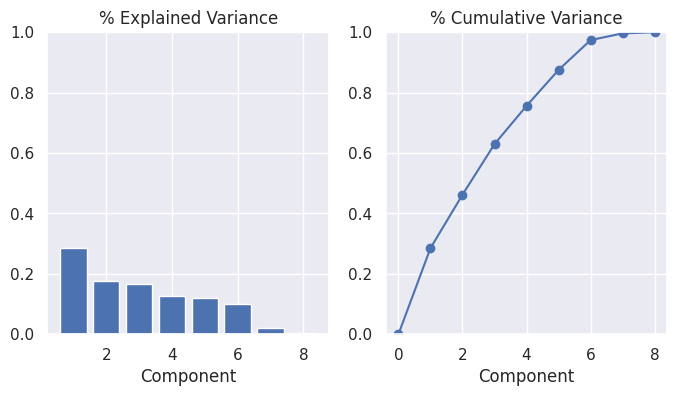

In [21]:
#determine % explained variance and use % cumulative variance for elbow method to determine number of PCs

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

# 5. OLS Regression Analysis

In [22]:
#generate OLS regression results for all features
import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Fri, 15 Oct 2021   Prob (F-statistic):          6.29e-206
Time:                        16:43:15   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -23.3312     26.586  

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
#initialize VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
#calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature        VIF
0            cement  15.456717
1              slag   3.329127
2            flyash   4.147833
3             water  82.157569
4  superplasticizer   5.471094
5   coarseaggregate  84.955779
6     fineaggregate  72.790995
7               age   1.699459


In [24]:
#print OLS summary for each feature
for i in X.columns:
    X_sm = sm.add_constant(X[i])
    model = sm.OLS(y,X_sm)
    print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                Fri, 15 Oct 2021   Prob (F-statistic):           1.32e-65
Time:                        16:43:15   Log-Likelihood:                -4214.6
No. Observations:                1030   AIC:                             8433.
Df Residuals:                    1028   BIC:                             8443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4425      1.297     10.365      0.0

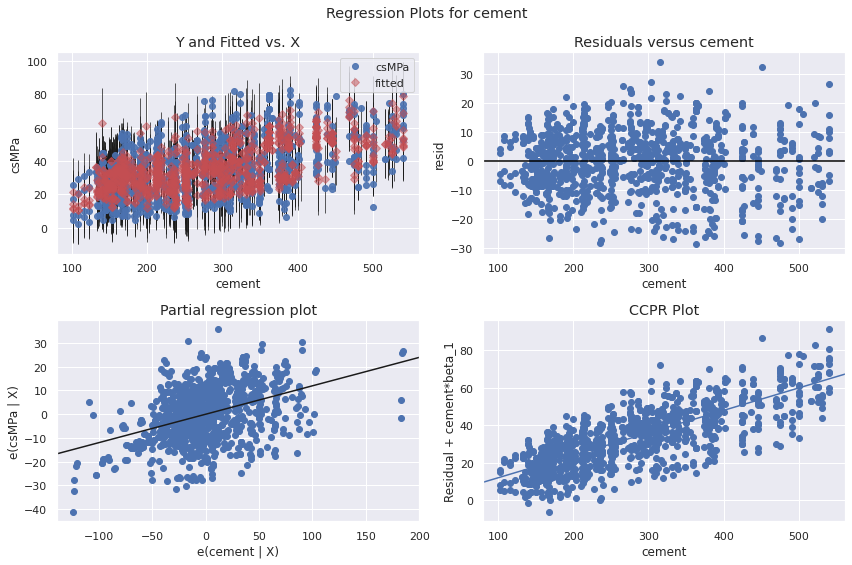

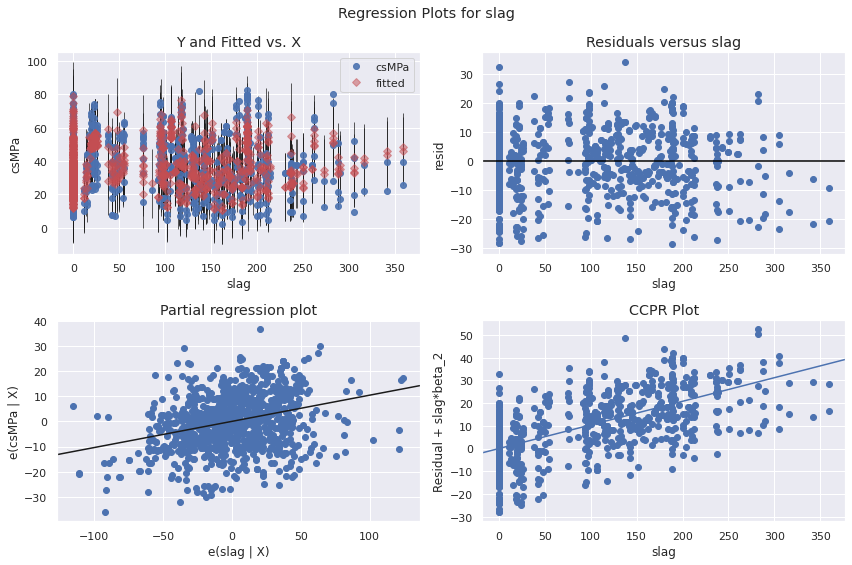

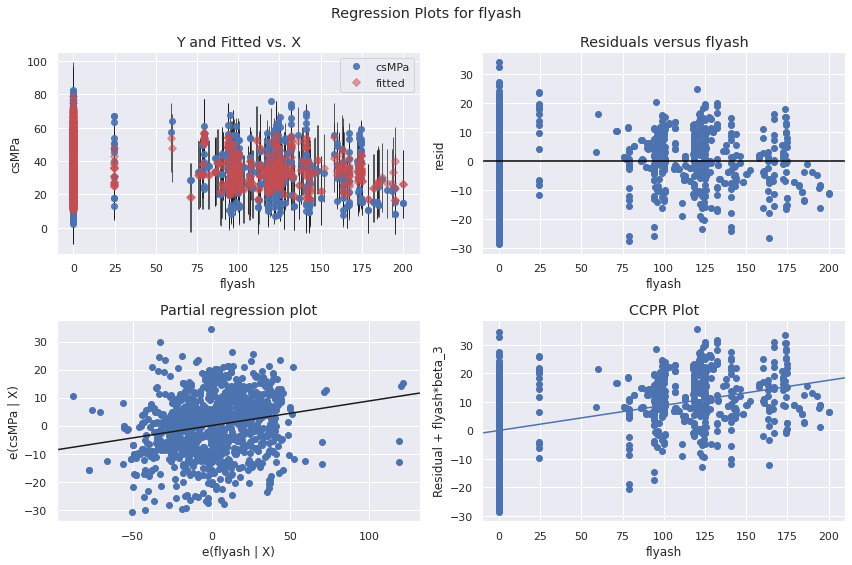

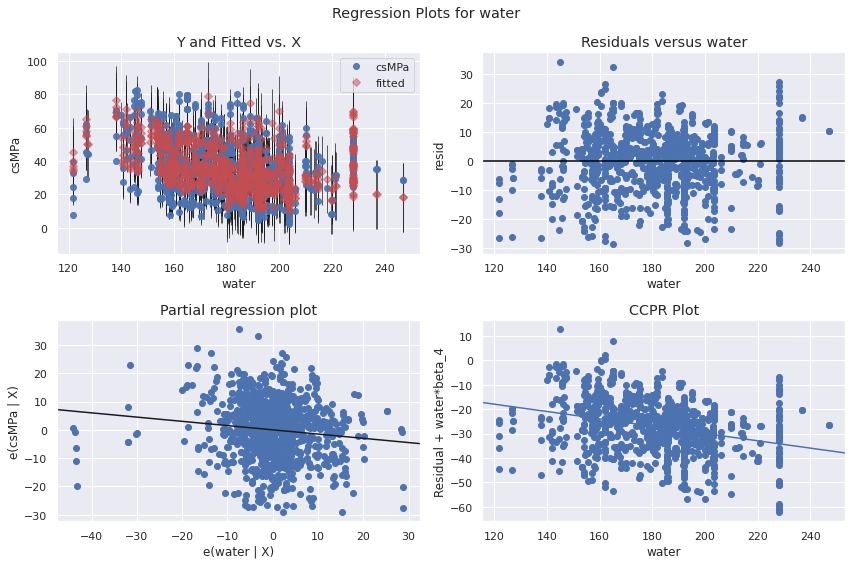

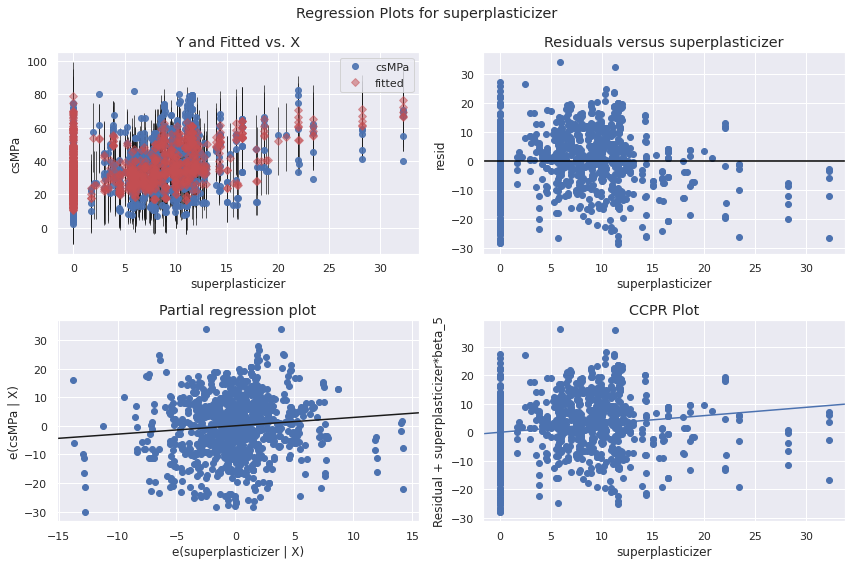

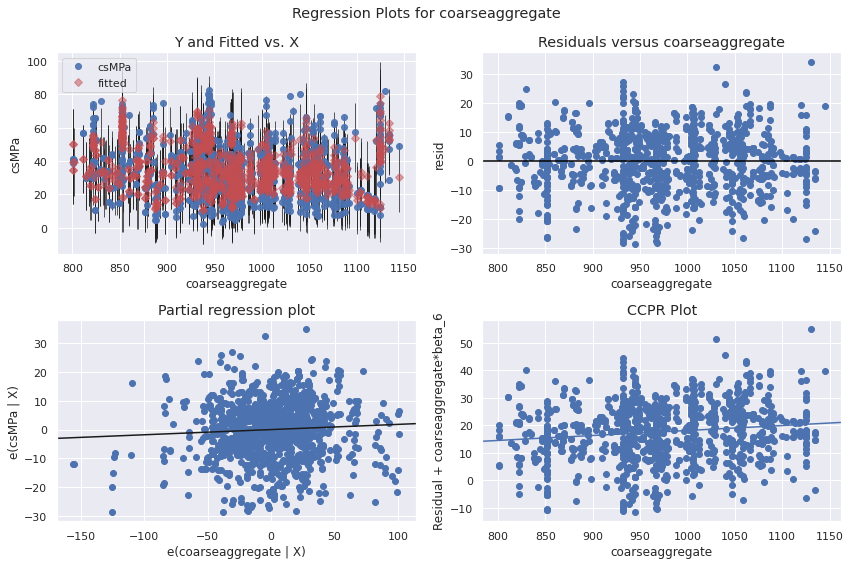

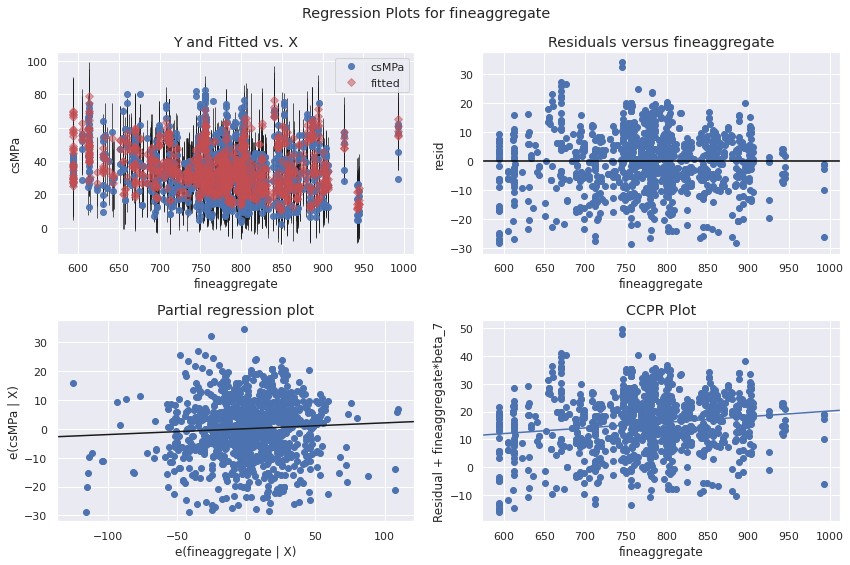

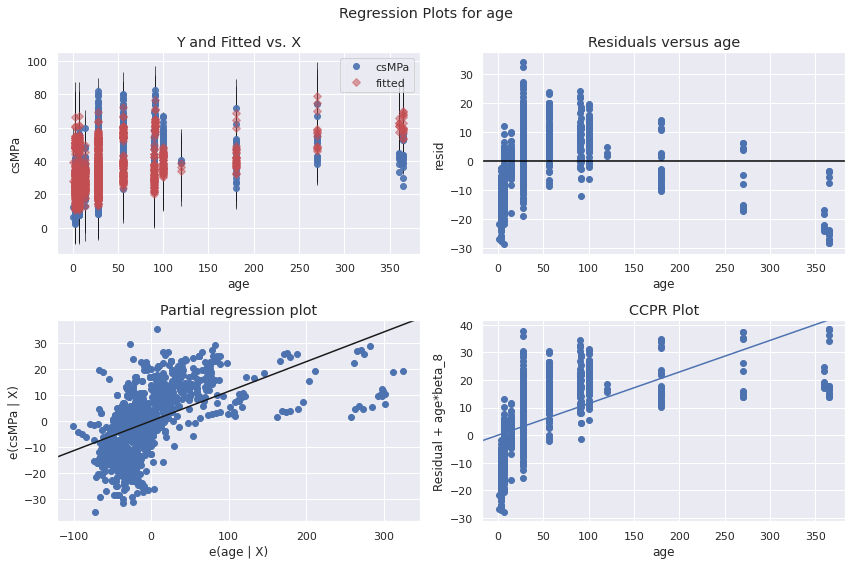

In [25]:
from statsmodels.formula.api import ols

#fit multiple linear regression model
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age', data=concrete_data).fit()

#create residual vs. predictor plot for 'assists'
for i in X.columns:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)
    fig.show()

# 6. Feature Engineering with OLS

In [26]:
#feature engineering using knowledge that water:cement ratio is an important factor for concrete strength
X['water_cement_ratio'] = X['water']/X['cement']

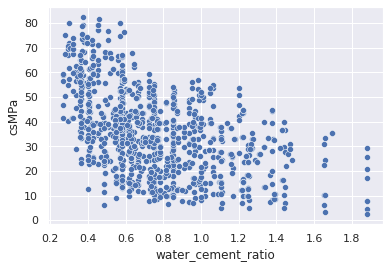

In [27]:
#plot water:cement ratio against compressive strength
sns.scatterplot(x=X['water_cement_ratio'], y=y)
plt.show()

In [28]:
#generate OLS regression results with water : cement ratio
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     183.6
Date:                Fri, 15 Oct 2021   Prob (F-statistic):          2.28e-206
Time:                        16:43:27   Log-Likelihood:                -3865.2
No. Observations:                1030   AIC:                             7750.
Df Residuals:                    1020   BIC:                             7800.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.1769     26

In [29]:
#generate OLS summary with only water : cement ratio
X_sm = sm.add_constant(X['water_cement_ratio'])
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     343.9
Date:                Fri, 15 Oct 2021   Prob (F-statistic):           1.86e-66
Time:                        16:43:27   Log-Likelihood:                -4212.6
No. Observations:                1030   AIC:                             8429.
Df Residuals:                    1028   BIC:                             8439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.7502      1

Looking at the p-value of the t-statistic: water : cement ratio has a strong association with compressive strength.

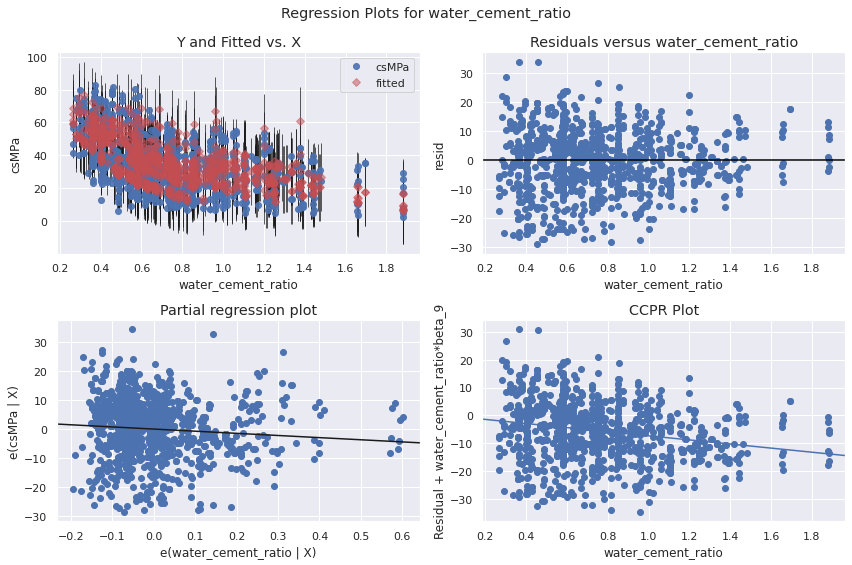

In [30]:
#copy water : cement ratio into concrete data
concrete_data['water_cement_ratio'] = X['water_cement_ratio']

#fit multiple linear regression model with water : cement ratio
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age + water_cement_ratio', data=concrete_data).fit()

#plot regression plots for water : cement ratio
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'water_cement_ratio', fig=fig)
fig.show()

Water : cement ratio residuals exhibits a near linear relationship.

# 7. Preparing Data for ML

In [31]:
#import ML preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [32]:
#column names
feature_names = X.columns

#train/test split 75% training, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

#numerical pipeline
scaler=MinMaxScaler()

#apply scaler to numerical data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8. ML Baselines

In [33]:
#import ML packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [34]:
#LinearRegression mean cross-validation
lm = LinearRegression()
lm.fit(X_train, y_train)
cv = cross_val_score(lm,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('LinearRegression')
print(mean(cv), '+/-', std(cv))

LinearRegression
-8.07027940327449 +/- 0.9042563541306468


In [35]:
#RandomForestRegressor mean cross-validation
rf = RandomForestRegressor(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('RandomForestRegressor')
print(mean(cv), '+/-', std(cv))

RandomForestRegressor
-3.741303784820554 +/- 0.1746349225638862


In [36]:
#GradientBoostingRegressor mean cross-validation
gbr = GradientBoostingRegressor(random_state = 1)
cv = cross_val_score(gbr,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('GradientBoostingRegressor')
print(mean(cv), '+/-', std(cv))

GradientBoostingRegressor
-3.8930976574254514 +/- 0.14455688824589297


In [37]:
#XGBoost mean cross-validation
xgb = XGBRegressor(random_state = 1)
cv = cross_val_score(xgb,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('XGBoost')
print(mean(cv), '+/-', std(cv))

XGBoost
-3.149192175484103 +/- 0.17553754090972187


# 9. Hyperparameter Tuning

In [38]:
#ml algorithm tuner
from sklearn.model_selection import GridSearchCV

#performance reporting function
def clf_performance(regressor, model_name):
    print(model_name)
    print('Best Score: {} +/- {}'.format(str(regressor.best_score_),str(regressor.cv_results_['std_test_score'][regressor.best_index_])))
    print('Best Parameters: ' + str(regressor.best_params_))

In [39]:
#LinearRegression GridSearchCV
lm = LinearRegression()
param_grid = {
                'fit_intercept':[True,False],
                'normalize':[True,False],
                'copy_X':[True, False]
}
clf_lm = GridSearchCV(lm, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_lm = clf_lm.fit(X_train,y_train)
clf_performance(best_clf_lm,'LinearRegressor')

LinearRegressor
Best Score: -8.060702077432467 +/- 0.8846924722871585
Best Parameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [40]:
#RanddomForestRegressor GridSearchCV
rf = RandomForestRegressor(random_state = 1)
param_grid = {
                'n_estimators': np.arange(160,200,2) , 
                'bootstrap': [True,False],
#                 'max_depth': [20,30,40],
#                 'max_features': ['auto','sqrt','log2'],
#                  'min_samples_leaf': [2],
#                  'min_samples_split': [6,8,10]
              }
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'RandomForestRegressor')

RandomForestRegressor
Best Score: -3.752174984879036 +/- 0.16962584492518898
Best Parameters: {'bootstrap': True, 'n_estimators': 192}


In [41]:
#GradientBoostingRegressor GridSearchCV
gbr = GradientBoostingRegressor(random_state = 1)
param_grid = {
                'n_estimators': [160], 
                'max_depth': [4],
                'max_features': ['auto'],
                'learning_rate': np.arange(.1,1,.1),
                'alpha': [0.0001],
                'min_samples_leaf': [2],
                'min_samples_split': np.arange(2,6,1)
              }
clf_gbr = GridSearchCV(gbr, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_gbr = clf_gbr.fit(X_train,y_train)
clf_performance(best_clf_gbr,'GradientBoostingRegressor')

GradientBoostingRegressor
Best Score: -3.0637915704624037 +/- 0.17629198413614053
Best Parameters: {'alpha': 0.0001, 'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160}


In [42]:
#XGBoost GridSearchCV
xgb = XGBRegressor(random_state = 1)
param_grid = {
#               'nthread':[4],
#               'objective':['reg:linear'],
#               'learning_rate': [0.3],
              'max_depth': [4],
#               'min_child_weight': [1],
#               'subsample': [1],
#               'colsample_bytree': np.arange(0.5,1,0.1),
              'n_estimators': [500]
              }
clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGBoost')

XGBoost
Best Score: -3.020177287831604 +/- 0.18068834764455305
Best Parameters: {'max_depth': 4, 'n_estimators': 500}


# 10. Assessing Models

In [43]:
#import metrics packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
#GradientBoostingRegressor metrics
gbr = GradientBoostingRegressor(alpha = 0.0001,
                                learning_rate= 0.2,
                                max_depth= 4,
                                max_features='auto',
                                min_samples_leaf= 2,
                                min_samples_split= 2,
                                n_estimators= 160,
                                random_state = 1)
gbr.fit(X_train,y_train)
tpred_gbr=gbr.predict(X_test)
print('GradientBoostingRegressor')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_gbr)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_gbr))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_gbr)))
print('R-squared: {}'.format(r2_score(y_test,tpred_gbr)))

GradientBoostingRegressor
MSE: 19.928264399385675
RMSE: 4.464108466355368
MAE: 3.0586929775691822
R-squared: 0.9252890876328432


In [45]:
#XGBoost metrics
xgb = XGBRegressor(max_depth=4,
                   n_estimators=500,
                   random_state = 1)
xgb.fit(X_train,y_train)
tpred_xgb=xgb.predict(X_test)
print('XGBoost')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_xgb)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_xgb))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_xgb)))
print('R-squared: {}'.format(r2_score(y_test,tpred_xgb)))

XGBoost
MSE: 17.557246580616614
RMSE: 4.190136821228707
MAE: 2.824839199236197
R-squared: 0.9341780154857116


# 11. Feature Importance

In [46]:
#import packages for explaining feature importance
import eli5
from eli5.sklearn import PermutationImportance

In [47]:
#permutation importance from xgboost
perm = PermutationImportance(xgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(feature_names), top=len(feature_names))

Weight,Feature
0.9126 ± 0.1335,age
0.4932 ± 0.0844,water_cement_ratio
0.1878 ± 0.0439,slag
0.1332 ± 0.0161,water
0.0837 ± 0.0158,fineaggregate
0.0426 ± 0.0082,coarseaggregate
0.0396 ± 0.0058,superplasticizer
0.0365 ± 0.0022,cement
0.0085 ± 0.0030,flyash
